# Intel Images: Preprocessing and Creating Feature Vectors

By Amanda Murray, John Van, Charles Lucas, and Kang Wang

This notebook includes preprocessing steps, generating feature vectors, and initial visualizations for the paper.

This notebook contains the following sections:

    1. Pre-processing
        -Create CSVs and Train/Test Split
        -Pre-process images
    2. Object Count
        -Generate
        -Visualize
    3. Luminence Histograms
        -Generate
        -Visualize
    4. HOG
        -Generate
        -Visualize
    5. Brisk/Bag of Visual Words
        -Generate
        -Visualize
    6. ResNET
        -Generate
        -Visualize

In [583]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import urllib
import os
import cv2

import skimage
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from skimage import exposure
from skimage.feature import hog
from skimage import data, color
from sklearn.decomposition import PCA

from scipy.cluster.vq import kmeans, vq

import warnings

# 1. Preprocessing

### Create CSVs with Image Paths and Train/Val/Test Split

Generate 3 separate csvs that contain image paths and labels for training set, val set, and test set

In [539]:
test_path = './seg_test/seg_test/'
train_path = './seg_train/seg_train/'

def dataframe_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    building_path = 'buildings/'
    forest_path = 'forest/'
    glacier_path = 'glacier/'
    mountain_path = 'mountain/'
    sea_path = 'sea/'
    street_path = 'street/'
    
    building_path = os.path.join(filepath, building_path)
    forest_path = os.path.join(filepath, forest_path)
    glacier_path = os.path.join(filepath, glacier_path)
    mountain_path = os.path.join(filepath, mountain_path)
    sea_path = os.path.join(filepath, sea_path)
    street_path = os.path.join(filepath, street_path)

    def get_files_with_labels(folder_path, label):
        files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith('.jpg')]
        labels = [label] * len(files)
        return files, labels

    building_files, building_list = get_files_with_labels(building_path, 'building')
    forest_files, forest_list = get_files_with_labels(forest_path, 'forest')
    glacier_files, glacier_list = get_files_with_labels(glacier_path, 'glacier')
    mountain_files, mountain_list = get_files_with_labels(mountain_path, 'mountain')
    sea_files, sea_list = get_files_with_labels(sea_path, 'sea')
    street_files, street_list = get_files_with_labels(street_path, 'street')

    paths = building_files + forest_files + glacier_files + mountain_files + sea_files + street_files
    labels = building_list + forest_list + glacier_list + mountain_list + sea_list + street_list

    df = pd.DataFrame({'files': paths, 'labels': labels})

    return df

In [518]:
# #Create dataframe and split train/validation
# df = dataframe_img(train_path)

# # Define the percentage of data to assign to the validation set
# validation_split = 0.2

# # Create an empty 'train_or_val' column
# df['train_or_val'] = 'training'

# # Group the data by 'labels'
# groups = df.groupby('labels')

# # Update 10% of rows for each label to 'validation'
# for name, group in groups:
#     num_validation_samples = int(len(group) * validation_split)
#     validation_indices = np.random.choice(group.index, num_validation_samples, replace=False)
#     df.loc[validation_indices, 'train_or_val'] = 'validation'

# # Separate val and train
# df_train = df[df['train_or_val']=='training'].reset_index().drop('index', axis=1)
# df_val = df[df['train_or_val']=='validation'].reset_index().drop('index', axis=1)

# # Generate test set
# df_test =  dataframe_img(test_path)

# # Save all to csvs
# df_train.to_csv('train_data.csv')
# df_val.to_csv('val_data.csv')
# df_test.to_csv('test_data.csv')

In [540]:
# Read csvs
df_train = pd.read_csv('train_data.csv', index_col=0)
df_val = pd.read_csv('val_data.csv', index_col=0)
df_test = pd.read_csv('test_data.csv', index_col=0)

### Preprocess Images

Given that ~500 images are in grey scale, this code converts all images to grey scale. It also resizes images to 150x150, and does histogram equalization to equalize the contrast across images. 

In [520]:
# read image without histogram equalization
def read_image(in_path):
    # Check if the file path ends with ".jpg"
    if in_path.lower().endswith('.jpg'):
        #read as grey scale
        img = cv2.imread(in_path, 0)

        # Convert to floating-point image with intensity [0, 1]
        if np.max(img) > 1:
            img = img.astype(np.float32) / 255.0
        
        # Rescale
        standard = 150
        scale = standard / min(img.shape[:2])
        img = rescale(img, scale, anti_aliasing=False)
        img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
                  int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]

        return img

In [521]:
# read image with histogram equalization
def read_image_histequal(in_path):
    # Check if the file path ends with ".jpg"
    if in_path.lower().endswith('.jpg'):
        #read as grey scale
        img = cv2.imread(in_path, 0)

        # Histogram equalization
        img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
        img = cv2.equalizeHist(img)

        # Convert to floating-point image with intensity [0, 1]
        if np.max(img) > 1:
            img = img.astype(np.float32) / 255.0
        
        # Rescale
        standard = 150
        scale = standard / min(img.shape[:2])
        img = rescale(img, scale, anti_aliasing=False)
        img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
                  int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]

        #Convert to ubyte for many of the features
        img = skimage.img_as_ubyte(img)

        return img

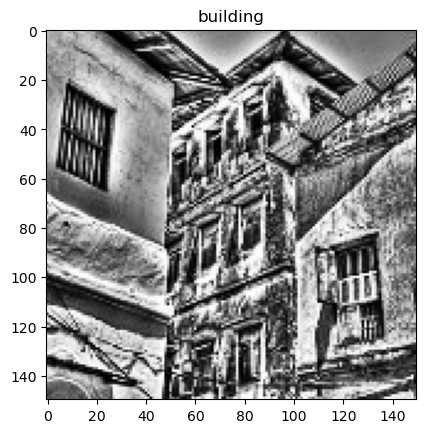

(150, 150)

In [522]:
# Plot one pre-processed image
img = read_image_histequal(df_train['files'][1000])
# Get the label for the image
label = df_train['labels'][1000]
# Display the image
plt.imshow(img, cmap='gray')  # 'cmap' specifies the colormap for grayscale
plt.title(label)  # Set the title to the label
plt.show()

img.shape

# 2. Object Count

### Generate

In [523]:
def object_count(dataframe):
    objects = []

    for filepath in dataframe['files']:
        image = read_image_histequal(filepath)
        blur = cv2.GaussianBlur(image, (11, 11), 0)
        edges = cv2.Canny(blur, 50, 150)
        dilated = cv2.dilate(edges, (1, 1), iterations=0) 
        (cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        objects.append(len(cnt))
    
    return objects

In [549]:
df_train['object_count'] = object_count(df_train)
df_val['object_count'] = object_count(df_val)
df_test['object_count'] = object_count(df_test)

### Visualize

In [471]:
labels = df_train['labels'].unique()
object_counts_by_label = {}
for label in labels:
    object_counts_by_label[label] = []
    for object_count in df_train[df_train['labels'] == label]['object_count']:
        object_counts_by_label[label].append(object_count)

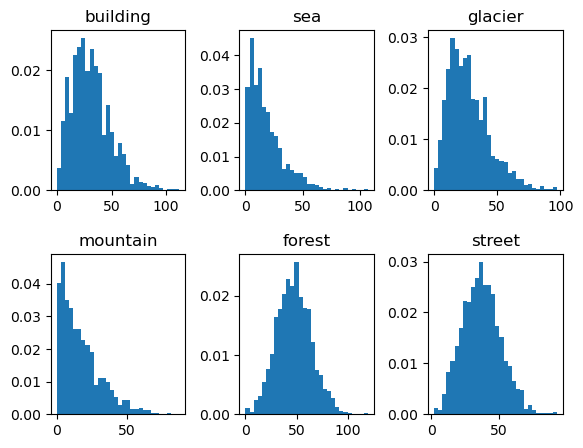

In [472]:
fig, ax = plt.subplots(nrows=2, ncols=3)
index = 0
ax_x = [0, 1, 2, 0, 1, 2]
ax_y = [0, 1, 0, 1, 0, 1]

for label, object_counts in object_counts_by_label.items():
    ax[ax_y[index], ax_x[index]].hist(object_counts, bins=30, density=True)
    ax[ax_y[index], ax_x[index]].set_title(label)
    index += 1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


In [ ]:
# Create a single plot for all histograms
fig, ax = plt.subplots()

# Plot smoothed line histograms with different colors for each label
for label, object_counts in object_counts_by_label.items():
    sns.kdeplot(object_counts, label=label)

# Set labels and title
ax.set_xlabel('Object Counts')
ax.set_ylabel('Density')
ax.set_title('Smoothed Histograms of Object Counts by Label')

# Add legend
ax.legend()

plt.show()

# 3. Luminence Histograms

### Generate 

In [525]:
#Create functions for generating datafram
def compute_histogram(image_path):
    '''this function reads an image and computes a histogram of gray scale pixel values'''
    image = read_image(image_path)
    hist, _ = np.histogram(image.flatten(), bins=25, range=[0, 1])
    return hist

def expand_lum_features(row):
    '''this function expands the histogram feature vector into separate columns'''
    return pd.Series(row['histogram_feature'], index=[f'lum_hist_{i+1}' for i in range(len(row['histogram_feature']))])

def add_lum_hist_features(dataframe):
    '''this function can be used to generate the feature vectors in a dataframe'''
    dataframe['histogram_feature'] = dataframe['files'].apply(lambda x: compute_histogram(x))
    
    expanded_lum_df = pd.concat([dataframe, dataframe.apply(expand_lum_features, axis=1)], axis=1)
    expanded_lum_df = expanded_lum_df.drop('histogram_feature', axis=1)
    
    return expanded_lum_df

In [550]:
#Add luminence columns to existing dataframes
df_train = add_lum_hist_features(df_train)
df_val = add_lum_hist_features(df_val)
df_test = add_lum_hist_features(df_test)

In [527]:
# Check
df_train

files    labels train_or_val  \
0          ./seg_train/seg_train/buildings/0.jpg  building     training   
1       ./seg_train/seg_train/buildings/1001.jpg  building     training   
2      ./seg_train/seg_train/buildings/10014.jpg  building     training   
3      ./seg_train/seg_train/buildings/10018.jpg  building     training   
4      ./seg_train/seg_train/buildings/10056.jpg  building     training   
...                                          ...       ...          ...   
11225      ./seg_train/seg_train/street/9961.jpg    street     training   
11226      ./seg_train/seg_train/street/9967.jpg    street     training   
11227      ./seg_train/seg_train/street/9978.jpg    street     training   
11228      ./seg_train/seg_train/street/9989.jpg    street     training   
11229       ./seg_train/seg_train/street/999.jpg    street     training   

       object_count  lum_hist_1  lum_hist_2  lum_hist_3  lum_hist_4  \
0                 5         410         257         331         478   
1                17         508         522         919        1239   
2                46         451         640         491         586   
3                36         353         226        5700        7166   
4                40         245         289         453         520   
...             ...         ...         ...         ...         ...   
11225            23        4519        1777        1408        1304   
11226            44         223         358        1022         982   
11227            49        1109        1010         965         907   
11228            46        1269        1671        2342        3045   
11229            64        1418         973        1216        1544   

       lum_hist_5  lum_hist_6  ...  lum_hist_16  lum_hist_17  lum_hist_18  \
0             617         770  ...          206          154          144   
1            1236        1210  ...         1154         1088         1621   
2             589         493  ...         1195         1381         1606   
3            1368         858  ...          186          176          181   
4             724        1306  ...          608          557         1101   
...           ...         ...  ...          ...          ...          ...   
11225        1006        1011  ...          300          198          186   
11226         727         659  ...         1112         1162         1132   
11227         813         951  ...         1024         1026          793   
11228        3350        2474  ...           91           78           58   
11229        1558        1599  ...          686          537          520   

       lum_hist_19  lum_hist_20  lum_hist_21  lum_hist_22  lum_hist_23  \
0              143          112          116          102          104   
1             1548         1622          864          257          332   
2             1507         1094         1363         1852         1205   
3              186          238          501          766          510   
4             3183         2038          599          377          364   
...            ...          ...          ...          ...          ...   
11225          166          126          112           85           88   
11226         1197         1025         1021          773          764   
11227          458          269          156          102          237   
11228           49           47           39           25           26   
11229          423          356          359          282          244   

       lum_hist_24  lum_hist_25  
0              971         9434  
1              175           36  
2              739          461  
3              352          579  
4              669          491  
...            ...          ...  
11225           91         1248  
11226          797         2521  
11227          649         1982  
11228           31          106  
11229          263          457  

[11230 rows x 29 columns]

### Visualize

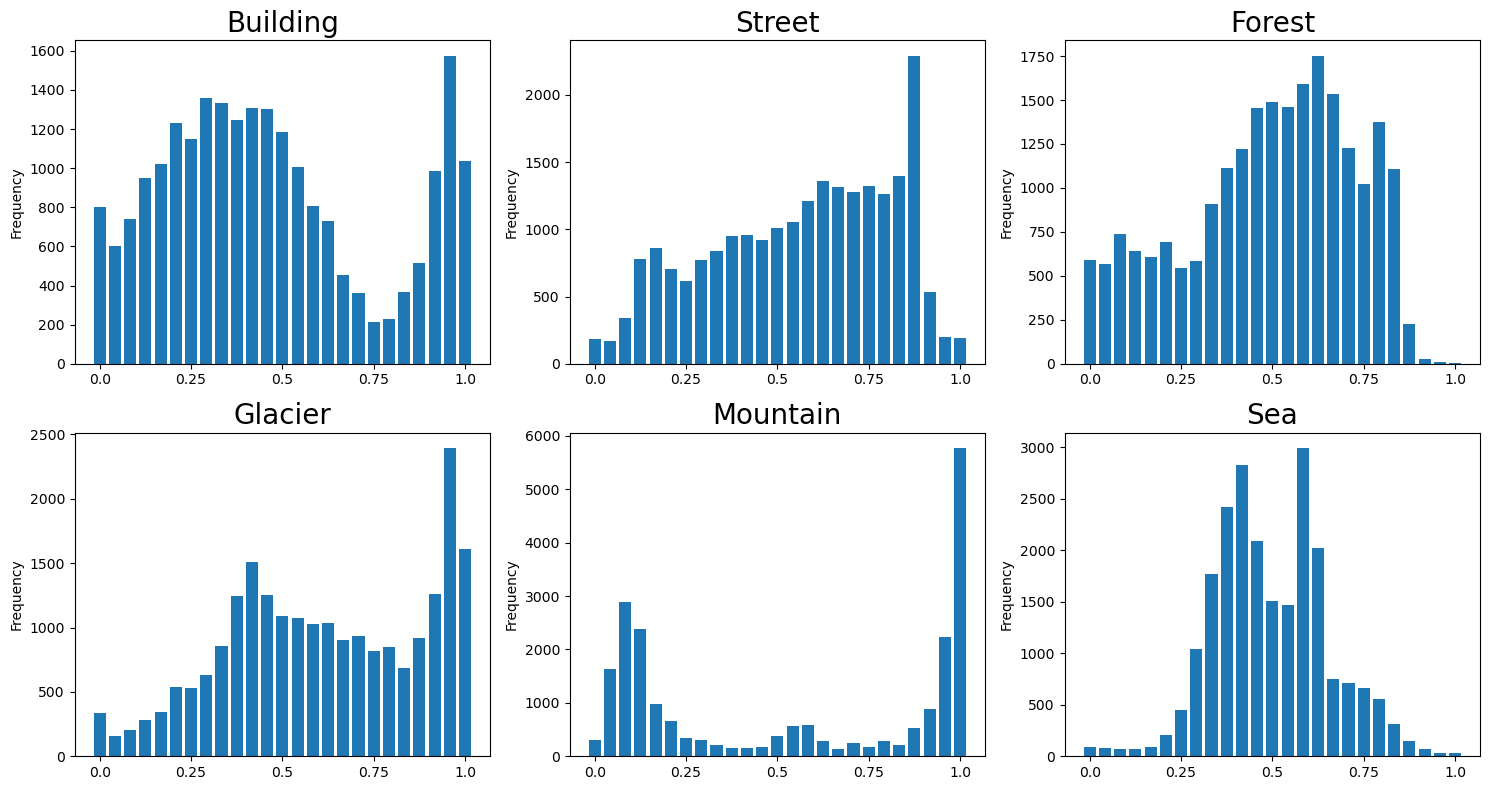

In [437]:
### Create histograms for 6 sample images
# Images
img_building = df_train[df_train['labels']=='building']['files'].to_list()[20]
img_street = df_train[df_train['labels']=='street']['files'].to_list()[20]
img_forest = df_train[df_train['labels']=='forest']['files'].to_list()[20]
img_glacier = df_train[df_train['labels']=='glacier']['files'].to_list()[20]
img_mountain = df_train[df_train['labels']=='mountain']['files'].to_list()[20]
img_sea = df_train[df_train['labels']=='sea']['files'].to_list()[20]

imgs = {
    'Building': img_building,
    'Street': img_street,
    'Forest': img_forest,
    'Glacier': img_glacier,
    'Mountain': img_mountain,
    'Sea': img_sea
}

# Plot histograms for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for (label, image_path), ax in zip(imgs.items(), axes.flatten()):
    # Calculate the histogram
    hist_data = np.histogram(read_image(image_path).flatten(), 25, [0, 1])[0]

    # Plot the histogram
    ax.bar(range(25), hist_data)
    ax.set_xticks(np.linspace(0, 24, 5))  # Adjust the number of ticks as needed
    ax.set_xticklabels(np.linspace(0, 1, 5))
    ax.set_title(f'{label}', fontsize=20)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [343]:
### Group arrays by label to generate overall histograms
# List of labels
labels = ['building', 'mountain', 'sea', 'glacier', 'forest', 'street']

# Initialize empty arrays for each label
img_arrays = [np.array([]) for _ in range(len(labels))]

# Iterate through each label
for i, label in enumerate(labels):
    label_imgs = df_train[df_train['labels'] == label]['files']
    
    # Concatenate pixel values for each image in the current label
    for image in label_imgs:
        img = read_image(image)
        img_arrays[i] = np.concatenate((img_arrays[i], np.array(img).flatten()), axis=None)

/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

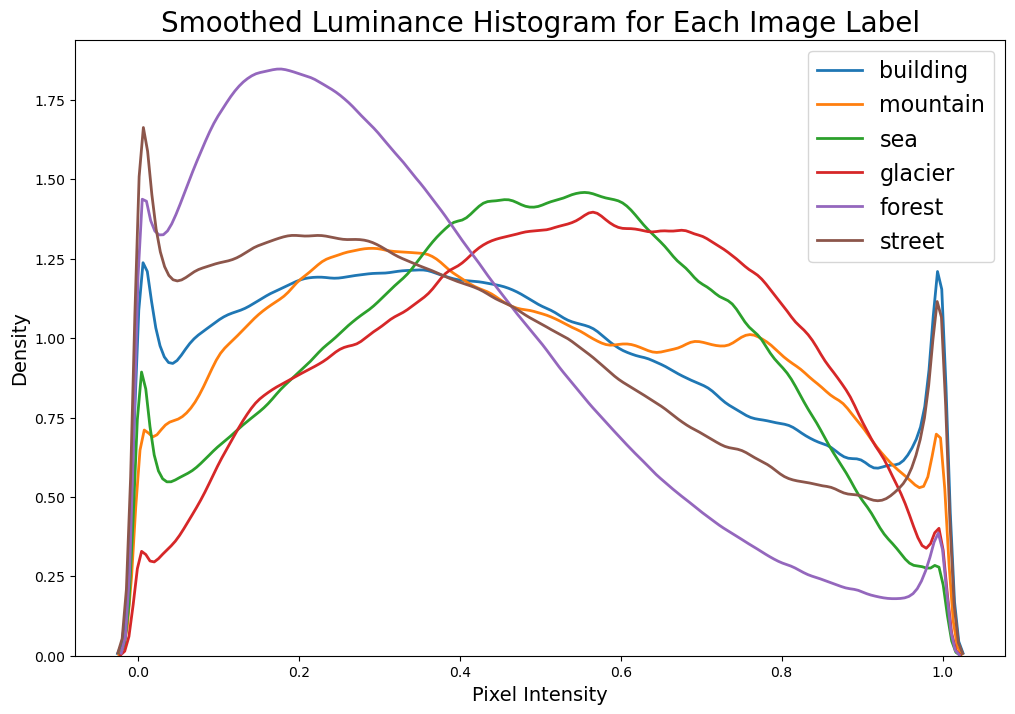

In [345]:
# Plot smoothed lines for each label with increased text size
plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    sns.kdeplot(data=img_arrays[i], fill=False, label=label, linewidth=2)

plt.xlabel('Pixel Intensity', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Density', fontsize=14)  # Adjust fontsize as needed
plt.title('Smoothed Luminance Histogram for Each Image Label', fontsize=20)  # Adjust fontsize as needed
plt.legend(fontsize=16)  # Adjust fontsize as needed
plt.show()

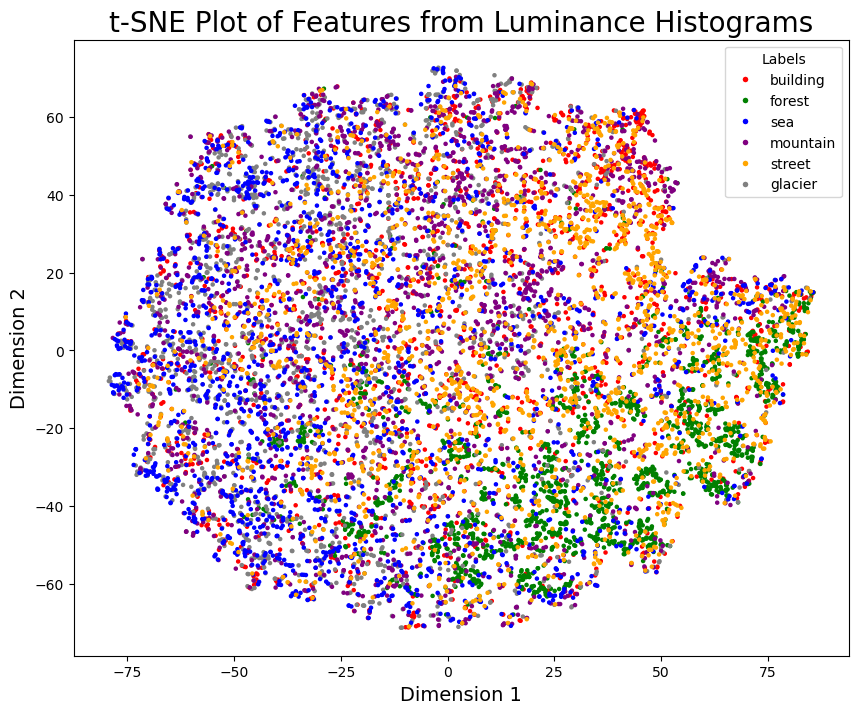

In [450]:
# tSNE for Luminance
columns_to_drop = ['files', 'labels', 'train_or_val', 'object_count']
X = df_train.drop(columns=columns_to_drop)
y = df_train['labels']

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors), s=5)

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=5, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from Luminance Histograms', fontsize=20)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.show()

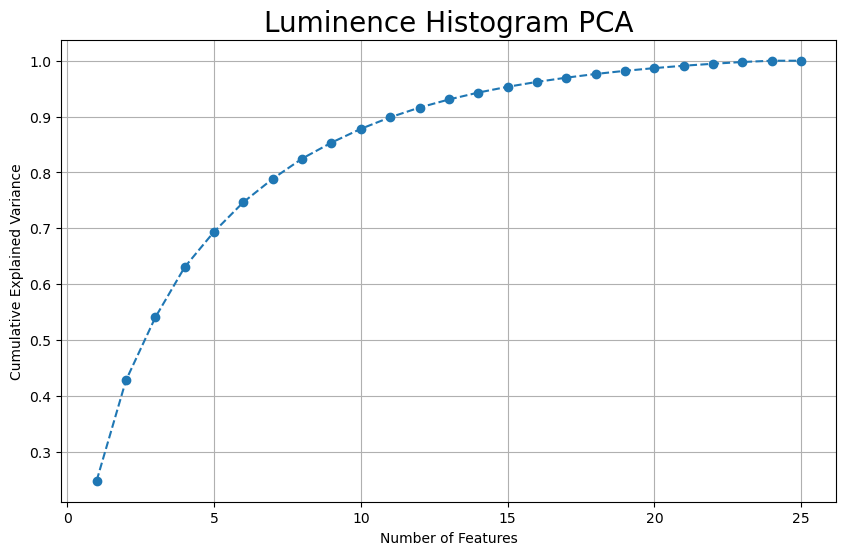

In [718]:
## PCA Visualisation

# # Drop specified columns

train_lum_pca = df_train.filter(regex='^lum', axis=1)

# Standardize the data 
scaler = StandardScaler()
train_lum_standardized = scaler.fit_transform(train_lum_pca)

# Apply PCA
pca = PCA()
pca.fit(train_lum_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Luminence Histogram PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# HOG Feature Vectors

### Generate

In [474]:
### Define functions
def extract_hog_features(img_path):
    ''' extract HOG features from an image '''
    img = read_image_histequal(img_path)
    
    # Calculate HOG features
    features, ___ = hog(img, visualize=True, pixels_per_cell = (10,10), cells_per_block = (1,1))
    
    return features.flatten()

def expand_HOG_features(row):
    ''' expand HOG feature vectors into individual columns '''
    return pd.Series(row['hog'], index=[f'hog_{i+1}' for i in range(len(row['hog']))])

def build_hog_df(dataframe):
    ''' generate dataframe with HOG values '''
    # Apply the function to each row in the DataFrame
    hog_features_df = pd.DataFrame(dataframe['files'].apply(extract_hog_features)).rename({'files':'hog'}, axis=1)

    # Concatenate the original DataFrame with the new ResNet features DataFrame
    result_df = pd.concat([dataframe, hog_features_df], axis=1)
    
    expanded_hog_df = pd.concat([result_df, result_df.apply(expand_HOG_features, axis=1)], axis=1)
    expanded_hog_df = expanded_hog_df.drop('hog', axis=1)
    
    return expanded_hog_df

In [551]:
# Add hog features to existing dataframes
df_train = build_hog_df(df_train)
df_val = build_hog_df(df_val)
df_test = build_hog_df(df_test)

In [636]:
# #Check
df_train

files    labels train_or_val  \
0          ./seg_train/seg_train/buildings/0.jpg  building     training   
1       ./seg_train/seg_train/buildings/1001.jpg  building     training   
2      ./seg_train/seg_train/buildings/10014.jpg  building     training   
3      ./seg_train/seg_train/buildings/10018.jpg  building     training   
4      ./seg_train/seg_train/buildings/10056.jpg  building     training   
...                                          ...       ...          ...   
11225      ./seg_train/seg_train/street/9961.jpg    street     training   
11226      ./seg_train/seg_train/street/9967.jpg    street     training   
11227      ./seg_train/seg_train/street/9978.jpg    street     training   
11228      ./seg_train/seg_train/street/9989.jpg    street     training   
11229       ./seg_train/seg_train/street/999.jpg    street     training   

       object_count  lum_hist_1  lum_hist_2  lum_hist_3  lum_hist_4  \
0                 5         410         257         331         478   
1                17         508         522         919        1239   
2                46         451         640         491         586   
3                36         353         226        5700        7166   
4                40         245         289         453         520   
...             ...         ...         ...         ...         ...   
11225            23        4519        1777        1408        1304   
11226            44         223         358        1022         982   
11227            49        1109        1010         965         907   
11228            46        1269        1671        2342        3045   
11229            64        1418         973        1216        1544   

       lum_hist_5  lum_hist_6  ...  hog_2016  hog_2017  hog_2018  hog_2019  \
0             617         770  ...  0.337915  0.348016  0.306815  0.348016   
1            1236        1210  ...  0.178815  0.230111  0.182894  0.203182   
2             589         493  ...  0.462124  0.389129  0.284457  0.245900   
3            1368         858  ...  0.371796  0.365507  0.344818  0.365507   
4             724        1306  ...  0.000000  0.018491  0.019167  0.026151   
...           ...         ...  ...       ...       ...       ...       ...   
11225        1006        1011  ...  0.234524  0.341036  0.341036  0.341036   
11226         727         659  ...  0.218873  0.362863  0.329858  0.362863   
11227         813         951  ...  0.333333  0.389476  0.207214  0.133700   
11228        3350        2474  ...  0.104968  0.135113  0.383960  0.276634   
11229        1558        1599  ...  0.352307  0.208350  0.298257  0.314171   

       hog_2020  hog_2021  hog_2022  hog_2023  hog_2024  hog_2025  
0      0.348016  0.348016  0.348016  0.271716  0.324569  0.348016  
1      0.460012  0.460012  0.457433  0.407047  0.271022  0.026582  
2      0.155493  0.278089  0.389129  0.389129  0.389129  0.389129  
3      0.283336  0.365507  0.365507  0.249741  0.265466  0.365507  
4      0.162986  0.982675  0.079228  0.010764  0.000000  0.000000  
...         ...       ...       ...       ...       ...       ...  
11225  0.341036  0.341036  0.341036  0.341036  0.263738  0.341036  
11226  0.362863  0.362863  0.362863  0.339798  0.316594  0.130967  
11227  0.170406  0.389476  0.389476  0.389476  0.389476  0.389476  
11228  0.507562  0.550235  0.346322  0.138884  0.229470  0.074369  
11229  0.377517  0.389859  0.389859  0.389859  0.389859  0.135838  

[11230 rows x 2054 columns]

### Visualize

In [477]:
def show_hog(image_path, label):
    '''show original image and hog feature vector side by side'''
    image = read_image_histequal(image_path)


    # Calculate HOG features
    ___, hog_image = hog(image, visualize=True, pixels_per_cell = (10,10), cells_per_block = (1,1))
    print(len(___))
    # Rescale intensity
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Plot the original and HOG images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title(f'{label}: Original')

    ax2.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax2.set_title(f'{label}: HOG')

    plt.show()

2025


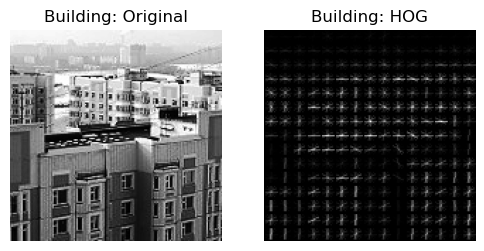

2025


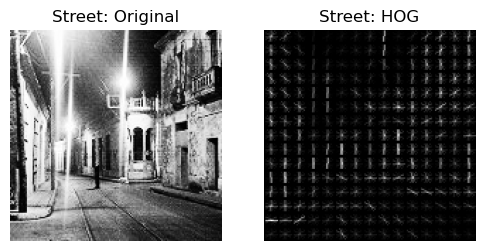

2025


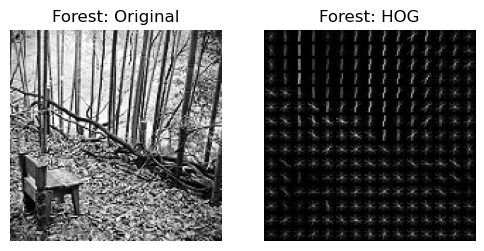

2025


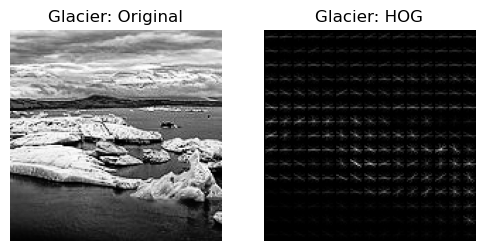

2025


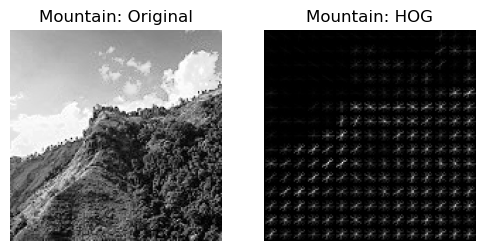

2025


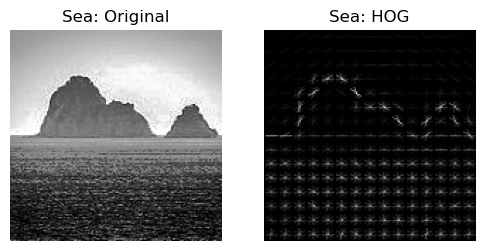

In [478]:
#Visual 6 sample HOG images

#Select images
img_building = df_train[df_train['labels']=='building']['files'].to_list()[10]
img_street = df_train[df_train['labels']=='street']['files'].to_list()[10]
img_forest = df_train[df_train['labels']=='forest']['files'].to_list()[10]
img_glacier = df_train[df_train['labels']=='glacier']['files'].to_list()[10]
img_mountain = df_train[df_train['labels']=='mountain']['files'].to_list()[10]
img_sea = df_train[df_train['labels']=='sea']['files'].to_list()[10]

# Add labels
imgs = {
    'Building': img_building,
    'Street': img_street,
    'Forest': img_forest,
    'Glacier': img_glacier,
    'Mountain': img_mountain,
    'Sea': img_sea
}

# Iterate over the images and show HOG features
for label, image in imgs.items():
    show_hog(image, label)


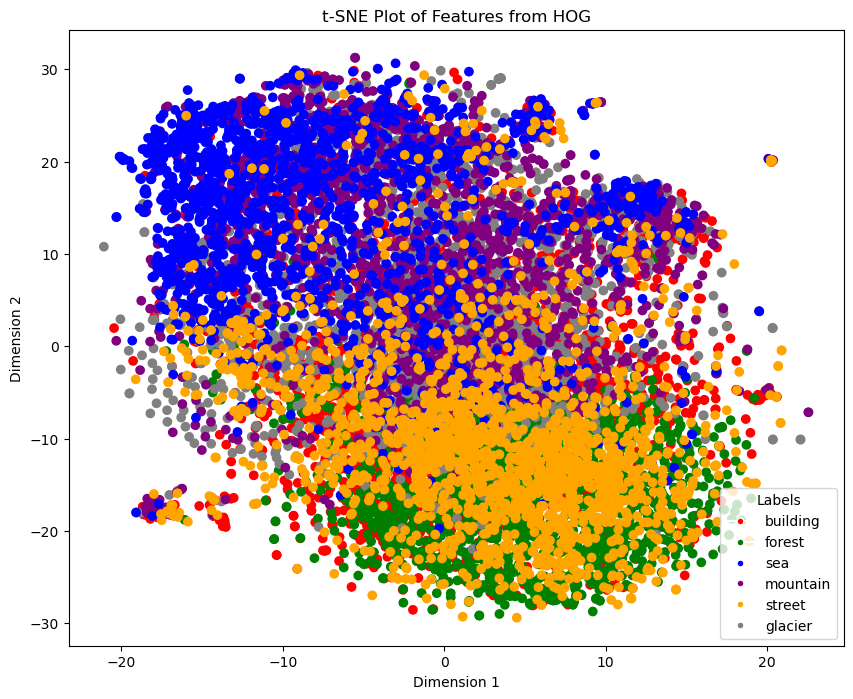

In [213]:
# tSNE for HOG
columns_to_drop = ['files', 'labels', 'train_or_val']
X = train_hog.drop(columns=columns_to_drop)
y = pivot_df['labels']

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=5, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from HOG')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

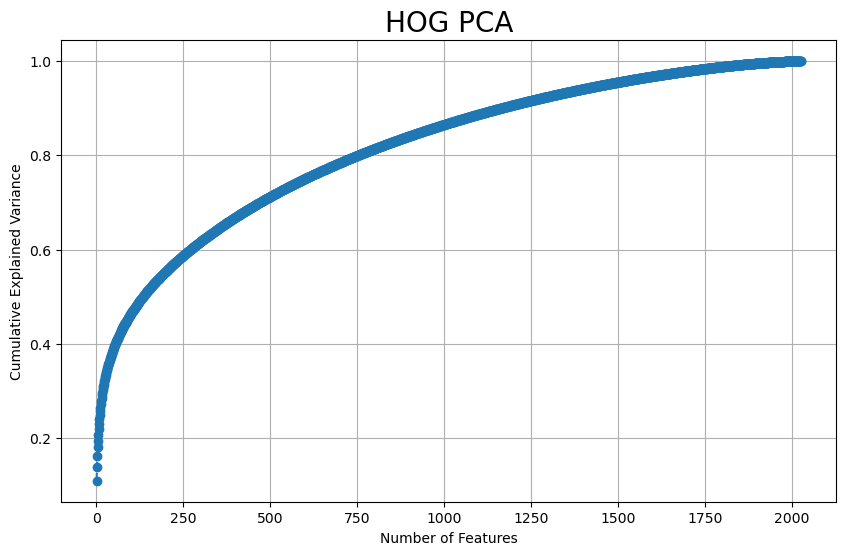

In [717]:
## PCA Visualisation

# # Drop specified columns
columns_to_drop = ['files', 'labels', 'train_or_val']
train_hog_pca = train_hog.drop(columns=columns_to_drop)

# Standardize the data 
scaler = StandardScaler()
train_hog_standardized = scaler.fit_transform(hog_pca)

# Apply PCA
pca = PCA()
pca.fit(train_hog_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('HOG PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# GLCM Feature Vectors

### Generate 

In [544]:
def GLCM_extractor(dataframe):
    '''This function takes in a series of paths and returns a dataframe of GLCM feature
    vectors
    '''
    file_series=dataframe['files']
    glcm_dataset = pd.DataFrame()
    
    for file in file_series:
        img = read_image_histequal(file)
        img = skimage.img_as_ubyte(img)
        size=4
        
        for angle in [0, np.pi/4, np.pi/2, 3*np.pi/2]:
            df = pd.DataFrame()
            df['files']=str(file)
            df['angle']=float(angle)

            GLCM = graycomatrix(img, [size], [angle])
            GLCM_Energy = graycoprops(GLCM, 'energy')[0]
            df['energy']= GLCM_Energy
            GLCM_corr = graycoprops(GLCM, 'correlation')[0]
            df['corr'] = GLCM_corr
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
            df['diss'] = GLCM_diss
            GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
            df['homogen'] = GLCM_hom
            GLCM_contr = graycoprops(GLCM, 'contrast')[0]
            df['contr'] = GLCM_contr

            df['files']=str(file)
            df['angle']=round(float(angle),2)

            glcm_dataset = pd.concat([glcm_dataset, df])
    
    #clean, join, and pivot
    final_glcm = pd.merge(glcm_dataset, dataframe, how='outer', on='files')
    pivot_df = final_glcm.pivot_table(index=['files'],
                          columns=['angle'],
                          values=['energy', 'corr', 'diss', 'homogen', 'contr'],
                          aggfunc='first')  # You can choose a different aggregation function if needed
    pivot_df.columns = [f'glcm_{value}_{angle:.2f}' for value,angle in pivot_df.columns]
    pivot_df=pivot_df.reset_index()
    
    return pivot_df

In [546]:
glcm_train = GLCM_extractor(df_train)
glcm_val = GLCM_extractor(df_val)
glcm_test = GLCM_extractor(df_test)

In [699]:
df_train2 = pd.merge(df_train, glcm_train, how='outer', on=['files'])
df_val2 = pd.merge(df_val, glcm_val, how='outer', on=['files'])
df_test2= pd.merge(df_test, glcm_test, how='outer', on=['files'])

In [557]:
df_val2

files    labels train_or_val  \
0     ./seg_train/seg_train/buildings/10006.jpg  building   validation   
1     ./seg_train/seg_train/buildings/10029.jpg  building   validation   
2     ./seg_train/seg_train/buildings/10032.jpg  building   validation   
3      ./seg_train/seg_train/buildings/1009.jpg  building   validation   
4     ./seg_train/seg_train/buildings/10113.jpg  building   validation   
...                                         ...       ...          ...   
2799       ./seg_train/seg_train/street/970.jpg    street   validation   
2800      ./seg_train/seg_train/street/9863.jpg    street   validation   
2801      ./seg_train/seg_train/street/9872.jpg    street   validation   
2802       ./seg_train/seg_train/street/994.jpg    street   validation   
2803      ./seg_train/seg_train/street/9959.jpg    street   validation   

      object_count  lum_hist_1  lum_hist_2  lum_hist_3  lum_hist_4  \
0               31         895        1000        1110         912   
1               13         826        2529        2733        1867   
2               35         361         261         365         463   
3               23         134         116         177         290   
4               23         398         375         464         544   
...            ...         ...         ...         ...         ...   
2799            49        1640        1187        1167        1181   
2800            18        2500        1446        1092        1053   
2801            16         386         268         353         497   
2802            37         265         163         193         255   
2803            50        1107         778         763         868   

      lum_hist_5  lum_hist_6  ...  glcm_diss_1.57  glcm_diss_4.71  \
0            906         887  ...       37.488174       37.488174   
1           1591        1459  ...       26.012694       26.012694   
2            540         679  ...       44.790365       44.790365   
3            675        1178  ...       33.808721       33.808721   
4            566         780  ...       36.817306       36.817306   
...          ...         ...  ...             ...             ...   
2799        1034        1113  ...       33.932055       33.932055   
2800        1182        1245  ...       26.241187       26.241187   
2801         799        1480  ...       24.926758       24.926758   
2802         303        1205  ...       30.630411       30.630411   
2803         696         871  ...       39.410274       39.410274   

      glcm_energy_0.00  glcm_energy_0.79  glcm_energy_1.57  glcm_energy_4.71  \
0             0.012319          0.010984          0.010666          0.010666   
1             0.023498          0.023163          0.024079          0.024079   
2             0.012883          0.011232          0.011390          0.011390   
3             0.029774          0.025220          0.025820          0.025820   
4             0.021474          0.019168          0.019244          0.019244   
...                ...               ...               ...               ...   
2799          0.010919          0.010616          0.011813          0.011813   
2800          0.013981          0.013804          0.014782          0.014782   
2801          0.020730          0.019562          0.020479          0.020479   
2802          0.025882          0.024670          0.024836          0.024836   
2803          0.009322          0.009104          0.010015          0.010015   

      glcm_homogen_0.00  glcm_homogen_0.79  glcm_homogen_1.57  \
0              0.075638           0.045357           0.047104   
1              0.081150           0.094947           0.113427   
2              0.066643           0.044962           0.047078   
3              0.123945           0.076563           0.088751   
4              0.100832           0.052370           0.058495   
...                 ...                ...                ...   
2799           0.053407           0.043986           0.059882   
28

### Visualize

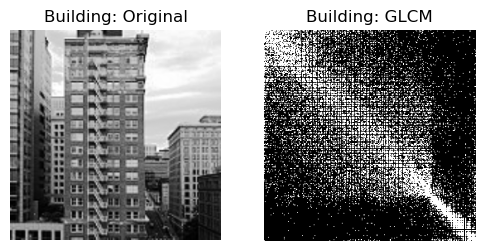

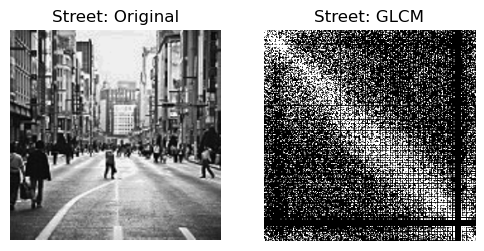

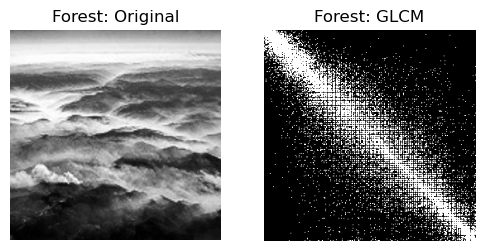

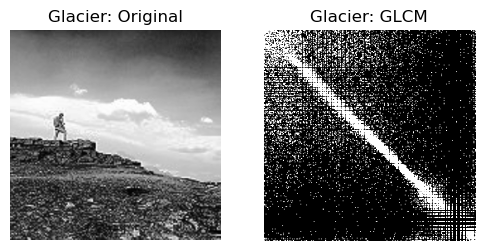

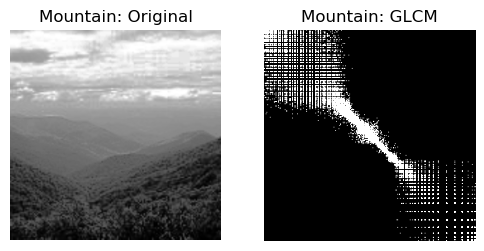

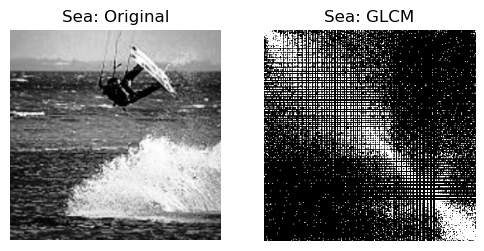

In [486]:
## Images of individual GLCM matrix examples
#identify and label images for plotting
img_building = df_train[df_train['labels']=='building']['files'].to_list()[20]
img_street = df_train[df_train['labels']=='street']['files'].to_list()[20]
img_forest = df_train[df_train['labels']=='forest']['files'].to_list()[20]
img_glacier = df_train[df_train['labels']=='glacier']['files'].to_list()[20]
img_mountain = df_train[df_train['labels']=='mountain']['files'].to_list()[20]
img_sea = df_train[df_train['labels']=='sea']['files'].to_list()[20]

imgs = {
    'Building': img_building,
    'Street': img_street,
    'Forest': img_forest,
    'Glacier': img_glacier,
    'Mountain': img_mountain,
    'Sea': img_sea
}

# Create subplots
for label, image in imgs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)

    img = read_image_histequal(image)
    GLCM = graycomatrix(img, [4], [0])
    
    ax1.axis('off')
    ax1.imshow(rescale(img, 1.7), cmap=plt.cm.gray)
    ax1.set_title(f'{label}: Original')
    ax1.set_aspect('equal')  # Set aspect ratio to be equal

    ax2.axis('off')
    ax2.imshow(GLCM[:, :, 0, 0], cmap=plt.cm.gray, vmin=0, vmax=1)
    ax2.set_title(f'{label}: GLCM')
    ax2.set_aspect('equal')  # Set aspect ratio to be equal

    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


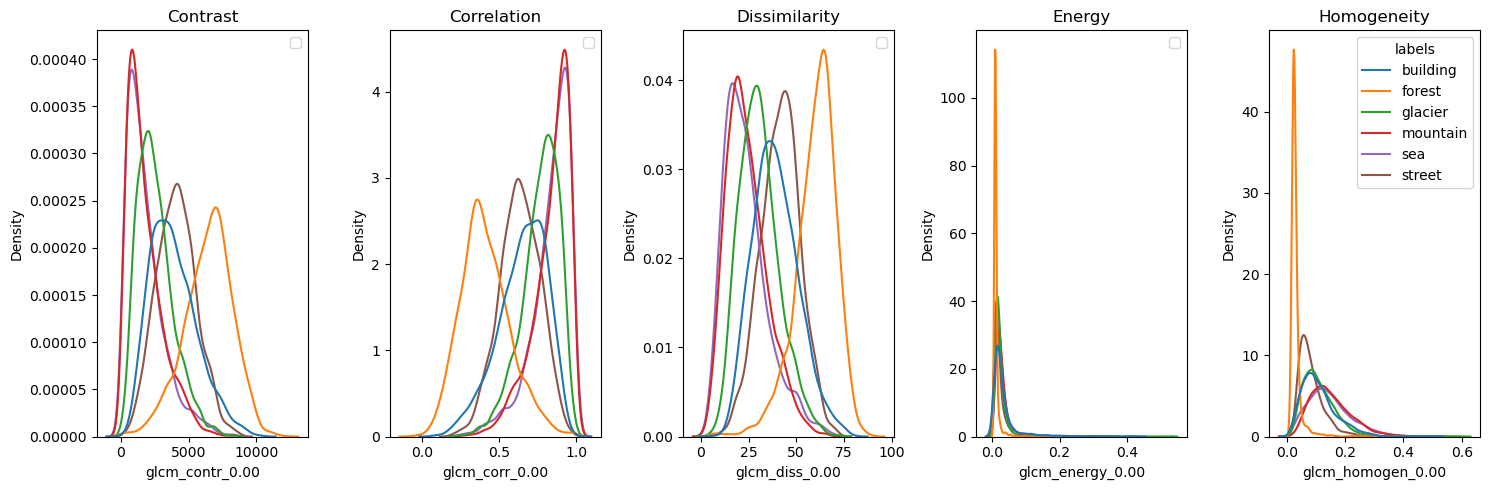

In [508]:
## Smooth histograms for angle 0
warnings.filterwarnings("ignore")

# Specify the columns of interest
columns_of_interest = ['glcm_contr_0.00', 'glcm_corr_0.00', 'glcm_diss_0.00', 'glcm_energy_0.00', 'glcm_homogen_0.00']
column_titles = ['Contrast', 'Correlation', 'Dissimilarity', 'Energy', 'Homogeneity']

# Create subplots
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(15, 5), sharey=False)

# Iterate over columns of interest
for i, (column, title) in enumerate(zip(columns_of_interest, column_titles)):
    # Plot smoothed histograms with different colors for each label
    sns.kdeplot(data=glcm_train, x=column, hue='labels', common_norm=False, fill=False, ax=axes[i])
    
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'{title}')

axes[0].legend(title='')
axes[1].legend(title='')
axes[2].legend(title='')
axes[3].legend(title='')
plt.tight_layout()
plt.show()

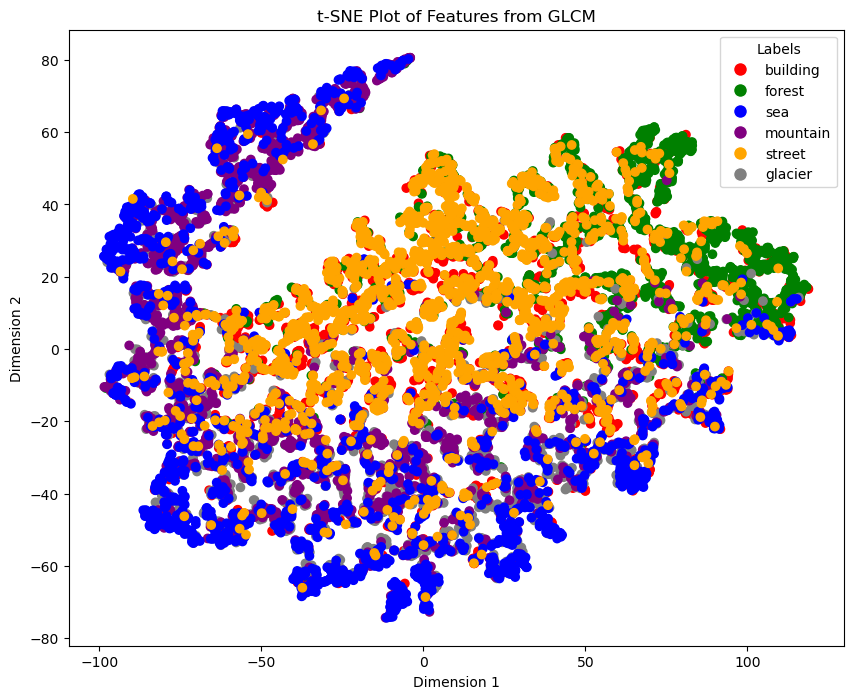

In [484]:
## tSNE for GLCM
# Create variables
columns_to_drop = ['files', 'labels', 'train_or_val']
X = glcm_train.drop(columns=columns_to_drop)
y = glcm_train['labels']

#Fit TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from GLCM')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

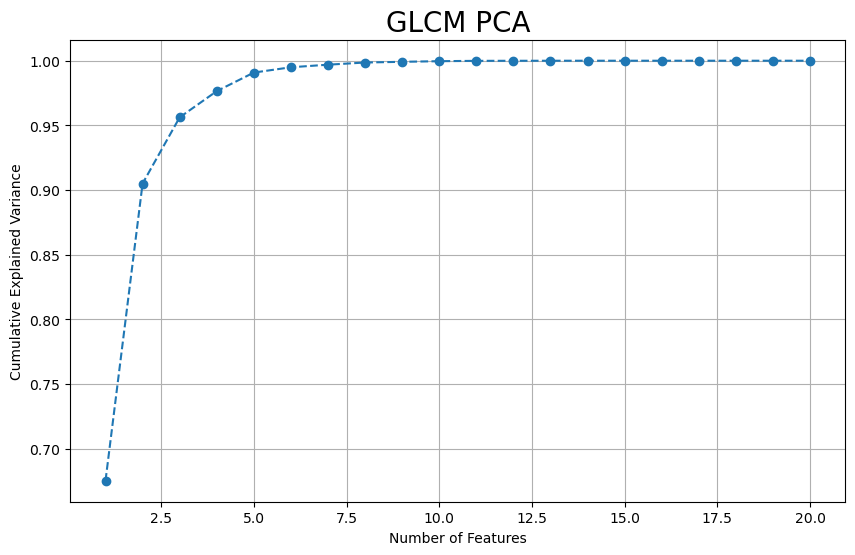

In [716]:
## PCA Visualisation

# # Drop specified columns
columns_to_drop = ['files']
glcm_pca = glcm_train.drop(columns=columns_to_drop)

# Standardize the data 
scaler = StandardScaler()
train_glcm_standardized = scaler.fit_transform(glcm_pca)

# Apply PCA
pca = PCA()
pca.fit(train_glcm_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('GLCM PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# BRISK and Visual Bag of Words

### Generate

In [604]:
# initialize BRISK
brisk = cv2.BRISK_create(30)

# Create list of key points and descriptors
descriptors_lst = []
keypoints_lst = []

for file in df_train['files']:
    img = read_image_histequal(file)
    (kpts, des) = brisk.detectAndCompute(img, None)
    descriptors_lst.append((file, des))
    keypoints_lst.append((file, kpts))
    
#Concatenate vectors
descriptors = descriptors_lst[0][1]
image_paths = []
none_images=[]
for image_path, descriptor in descriptors_lst[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        image_paths.append(image_path)
    else:
        none_images.append(image_path)

#Check for images without keypoints
none_images

[]

In [577]:
# Find 'words' using k-means
descriptors_float = descriptors.astype(float)

k = 200 #tested 100 and 150 as well
voc, variance = kmeans(descriptors_float, k, 1)


In [605]:
### TRAIN

# Count 'words'
im_features = np.zeros((len(df_train['files']), k), "float32")
for i in range(len(df_train['files'])):
    words, distance = vq(descriptors_lst[i][1], voc)
    for w in words: 
        im_features[i][w] +=1

#TF-idf Vecotrization
num_occur= np.sum((im_features > 0)*1, axis=0)
idf = np.array(np.log((1.0*len(df_train['files'])+1)/ (1.0+num_occur+1)), 'float32')

# Term Frequency (TF)
tf = im_features / np.sum(im_features, axis=1, keepdims=True)

# TF-IDF
tfidf = tf * idf

column_names = [f'bovw_{str(i)}' for i in range(1, 201)]
train_bovw_raw = pd.DataFrame(im_features, columns=column_names)
train_bovw_tfidf = pd.DataFrame(tfidf, columns=column_names)

In [606]:
### VALIDATION
# initialize BRISK
brisk = cv2.BRISK_create(30)

# Create list of key points and descriptors
descriptors_lst = []
keypoints_lst = []

for file in df_val['files']:
    img = read_image_histequal(file)
    (kpts, des) = brisk.detectAndCompute(img, None)
    descriptors_lst.append((file, des))
    keypoints_lst.append((file, kpts))
    
#Concatenate vectors
descriptors = descriptors_lst[0][1]
image_paths = []
none_images=[]
for image_path, descriptor in descriptors_lst[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        image_paths.append(image_path)
    else:
        none_images.append(image_path)
        
# Count 'words'
im_features = np.zeros((len(df_val['files']), k), "float32")
for i in range(len(df_val['files'])):
    words, distance = vq(descriptors_lst[i][1], voc)
    for w in words: 
        im_features[i][w] +=1

#TF-idf Vecotrization
num_occur= np.sum((im_features > 0)*1, axis=0)
idf = np.array(np.log((1.0*len(df_val['files'])+1)/ (1.0+num_occur+1)), 'float32')

# Term Frequency (TF)
tf = im_features / np.sum(im_features, axis=1, keepdims=True)

# TF-IDF
tfidf = tf * idf

column_names = [f'bovw_{str(i)}' for i in range(1, 201)]
val_bovw_raw = pd.DataFrame(im_features, columns=column_names)
val_bovw_tfidf = pd.DataFrame(tfidf, columns=column_names)


In [613]:
### TEST
# initialize BRISK
brisk = cv2.BRISK_create(30)

# Create list of key points and descriptors
descriptors_lst = []
keypoints_lst = []

for file in df_test['files']:
    img = read_image_histequal(file)
    (kpts, des) = brisk.detectAndCompute(img, None)
    descriptors_lst.append((file, des))
    keypoints_lst.append((file, kpts))
    
#Concatenate vectors
descriptors = descriptors_lst[0][1]
image_paths = []
none_images=[]
for image_path, descriptor in descriptors_lst[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        image_paths.append(image_path)
    else:
        none_images.append(image_path)


In [620]:
# Count 'words'
im_features = np.zeros((len(df_test['files']), k), "float32")
for i in range(len(df_test['files'])):
    # Check if descriptors_lst[i][1] is not None
    if descriptors_lst[i][1] is not None:
        words, distance = vq(descriptors_lst[i][1], voc)
        for w in words: 
            im_features[i][w] += 1
    # else:
        # print(f"Skipping iteration {i} because descriptors_lst[{i}][1] is None.")

#TF-idf Vecotrization
num_occur= np.sum((im_features > 0)*1, axis=0)
idf = np.array(np.log((1.0*len(df_test['files'])+1)/ (1.0+num_occur+1)), 'float32')

# Term Frequency (TF)
tf = im_features / np.sum(im_features, axis=1, keepdims=True)

# TF-IDF
tfidf = tf * idf

column_names = [f'bovw_{str(i)}' for i in range(1, 201)]
test_bovw_raw = pd.DataFrame(im_features, columns=column_names)
test_bovw_tfidf = pd.DataFrame(tfidf, columns=column_names)

In [622]:
#Add a column for total keypoints
test_bovw_tfidf['bovw_total'] = test_bovw_raw.sum(axis=1)
val_bovw_tfidf['bovw_total'] = val_bovw_raw.sum(axis=1)
train_bovw_tfidf['bovw_total'] = train_bovw_raw.sum(axis=1)

In [700]:
# Concatenate to full dataframe
df_val2 = pd.concat([df_val2, val_bovw_tfidf], axis=1)
df_train2 = pd.concat([df_train2, train_bovw_tfidf], axis=1)
df_test2 = pd.concat([df_test2, test_bovw_tfidf], axis=1)

In [681]:
train_bovw_tfidf

bovw_1    bovw_2    bovw_3    bovw_4    bovw_5    bovw_6    bovw_7  \
0      0.000000  0.000785  0.001412  0.001377  0.002766  0.004088  0.001222   
1      0.000000  0.000000  0.000479  0.000000  0.000938  0.002772  0.005802   
2      0.001359  0.000000  0.000000  0.003051  0.003065  0.000000  0.000000   
3      0.000859  0.001467  0.001649  0.000643  0.000000  0.002547  0.000000   
4      0.001920  0.003688  0.000737  0.001078  0.000722  0.001423  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
11225  0.000642  0.001096  0.001232  0.001922  0.001931  0.000951  0.000853   
11226  0.000783  0.001337  0.000902  0.000586  0.000589  0.000000  0.001041   
11227  0.002151  0.000000  0.000206  0.000805  0.004043  0.001593  0.000000   
11228  0.002046  0.000873  0.000589  0.001149  0.001539  0.001137  0.001020   
11229  0.002622  0.001958  0.000252  0.000491  0.001725  0.000728  0.003267   

         bovw_8    bovw_9   bovw_10  ...  bovw_192  bovw_193  bovw_194  \
0      0.001579  0.000000  0.003937  ...  0.000000  0.003019  0.001403   
1      0.003212  0.000454  0.000334  ...  0.000352  0.001365  0.000317   
2      0.005832  0.000000  0.000000  ...  0.001535  0.000000  0.002762   
3      0.003689  0.002505  0.002759  ...  0.000971  0.000940  0.001311   
4      0.000412  0.001749  0.001028  ...  0.000543  0.001313  0.000488   
...         ...       ...       ...  ...       ...       ...       ...   
11225  0.002205  0.002339  0.001031  ...  0.000000  0.000351  0.000653   
11226  0.002017  0.001712  0.002096  ...  0.000443  0.001714  0.000000   
11227  0.000462  0.000392  0.000288  ...  0.001823  0.001177  0.001913   
11228  0.000878  0.001491  0.000000  ...  0.000867  0.000840  0.001300   
11229  0.001125  0.000955  0.000702  ...  0.001296  0.002331  0.000833   

       bovw_195  bovw_196  bovw_197  bovw_198  bovw_199  bovw_200  bovw_total  
0      0.000506  0.000873  0.001921  0.000755  0.002762  0.001971       356.0  
1      0.002743  0.000592  0.000326  0.002048  0.000468  0.000891       525.0  
2      0.000747  0.002578  0.000000  0.003346  0.003060  0.000000       241.0  
3      0.001890  0.000815  0.000449  0.000705  0.000000  0.000000       381.0  
4      0.001584  0.000455  0.000501  0.001576  0.002523  0.000686       682.0  
...         ...       ...       ...       ...       ...       ...         ...  
11225  0.000706  0.001218  0.000335  0.001054  0.000964  0.000917       510.0  
11226  0.000000  0.000743  0.000409  0.001929  0.001176  0.001119       418.0  
11227  0.001773  0.001530  0.000561  0.001324  0.000404  0.000384       609.0  
11228  0.000844  0.000485  0.000267  0.000840  0.000768  0.000365       640.0  
11229  0.001261  0.002177  0.000685  0.001883  0.001231  0.001405       999.0  

[11230 rows x 201 columns]

### Visualize

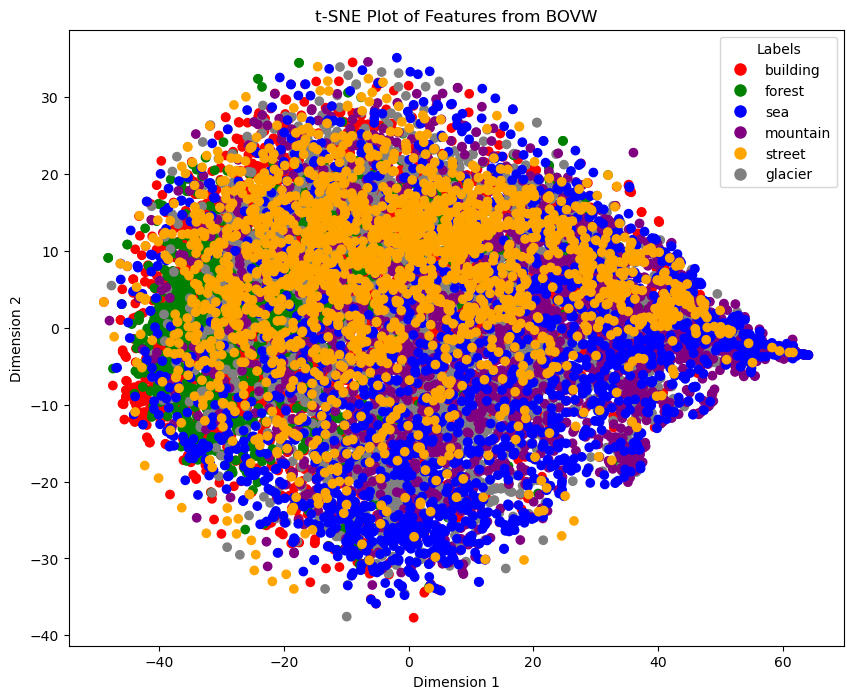

In [682]:
columns_to_drop = ['bovw_total']
X = train_bovw_tfidf.drop(columns=columns_to_drop)
y = df_train['labels']

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from BOVW')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

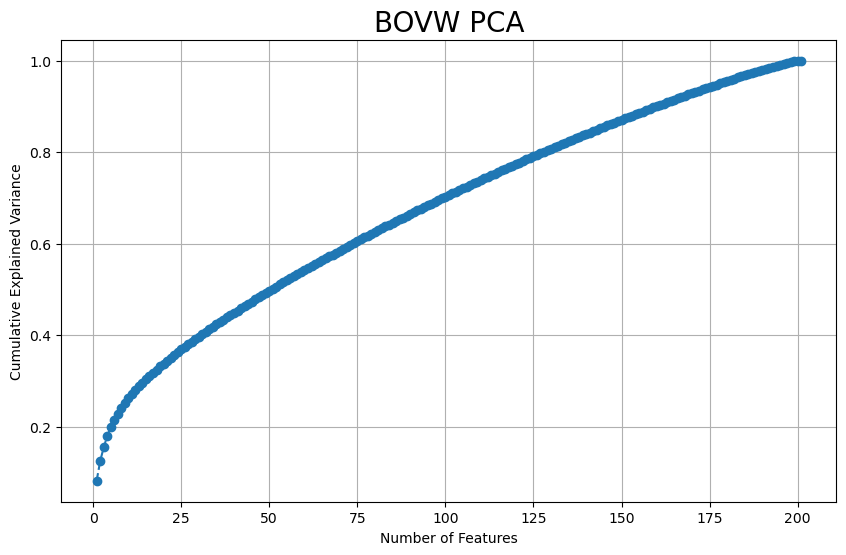

In [714]:
## PCA Visualisation

# # Drop specified columns
# columns_to_drop = ['files', 'labels', 'train_or_val']
# train_resnet = train_resnet.drop(columns=columns_to_drop)

# Standardize the data 
scaler = StandardScaler()
train_BOVW_standardized = scaler.fit_transform(train_bovw_tfidf)

# Apply PCA
pca = PCA()
pca.fit(train_BOVW_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('BOVW PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

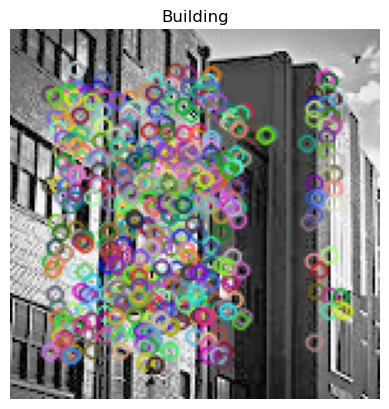

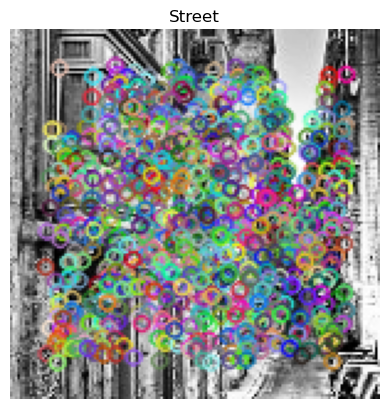

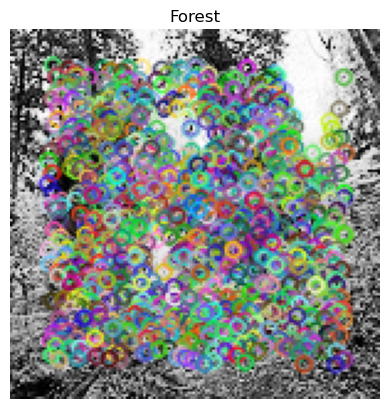

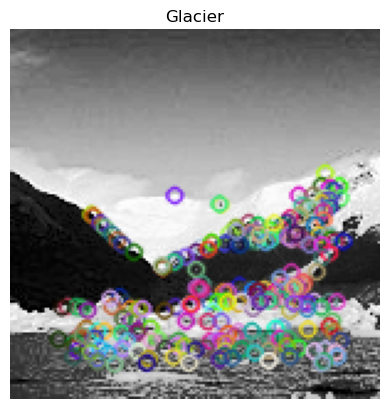

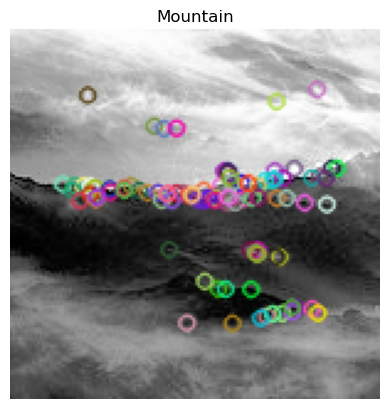

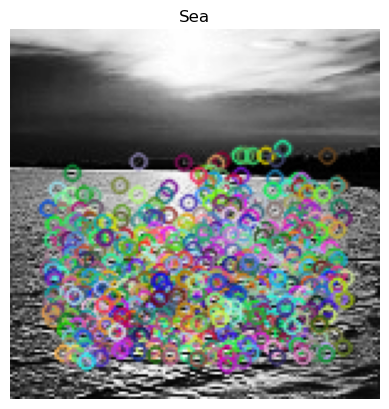

In [677]:
def display_keypoints(image_path, title):
    img = read_image_histequal(image_path)
    (kpts, des) = brisk.detectAndCompute(img, None)
    img_with_keypoints = cv2.drawKeypoints(img, kpts, None, flags=0)
    
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Assuming read_image_histequal and brisk are already defined

# Select images
img_building = df_train[df_train['labels'] == 'building']['files'].iloc[70]
img_street = df_train[df_train['labels'] == 'street']['files'].iloc[70]
img_forest = df_train[df_train['labels'] == 'forest']['files'].iloc[70]
img_glacier = df_train[df_train['labels'] == 'glacier']['files'].iloc[70]
img_mountain = df_train[df_train['labels'] == 'mountain']['files'].iloc[70]
img_sea = df_train[df_train['labels'] == 'sea']['files'].iloc[70]

# Add labels
imgs = {
    'Building': img_building,
    'Street': img_street,
    'Forest': img_forest,
    'Glacier': img_glacier,
    'Mountain': img_mountain,
    'Sea': img_sea
}

# Display keypoints for each image
for label, image_path in imgs.items():
    display_keypoints(image_path, label)

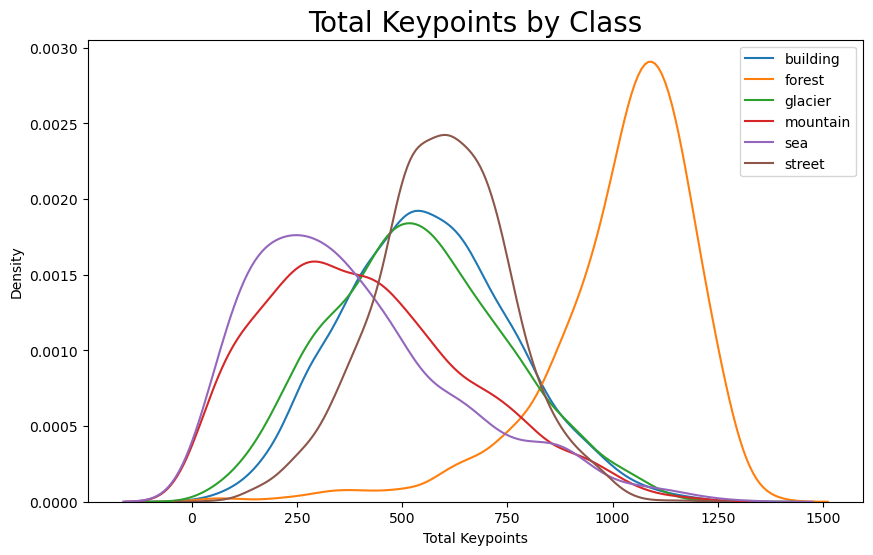

In [722]:
# Group the DataFrame by the 'labels' column
filtered_df = df_train2.filter(regex='^bovw', axis=1)
labels_column = df_train2['labels']
result_grouped = pd.concat([filtered_df, labels_column], axis=1).groupby('labels')

# Plot a kernel density estimate for each label
plt.figure(figsize=(10, 6))

for label, group in result_grouped:
    sns.kdeplot(group['bovw_total'], label=label)

plt.xlabel(f'Total Keypoints')
plt.ylabel('Density')
plt.title(f'Total Keypoints by Class', fontsize=20)
plt.legend()
plt.show()

# ResNET50

### Generate 

In [661]:
#### NOTE: ResNET Features are calculated in a separate ResNET Notebook and imported here
train_resnet = pd.read_csv('train_resnet.csv', index_col=0)
val_resnet = pd.read_csv('val_resnet.csv', index_col=0)
test_resnet = pd.read_csv('test_resnet.csv', index_col=0)

In [662]:
train_resnet

files    labels train_or_val  \
0          ./seg_train/seg_train/buildings/0.jpg  building     training   
1       ./seg_train/seg_train/buildings/1001.jpg  building     training   
2      ./seg_train/seg_train/buildings/10014.jpg  building     training   
3      ./seg_train/seg_train/buildings/10018.jpg  building     training   
4      ./seg_train/seg_train/buildings/10056.jpg  building     training   
...                                          ...       ...          ...   
11225      ./seg_train/seg_train/street/9961.jpg    street     training   
11226      ./seg_train/seg_train/street/9967.jpg    street     training   
11227      ./seg_train/seg_train/street/9978.jpg    street     training   
11228      ./seg_train/seg_train/street/9989.jpg    street     training   
11229       ./seg_train/seg_train/street/999.jpg    street     training   

              res_1         res_2         res_3         res_4         res_5  \
0      6.654819e-06  1.526390e-07  7.366177e-06  1.076602e-05  1.893316e-06   
1      4.836220e-08  3.873964e-08  2.382573e-06  1.261549e-06  6.436675e-07   
2      6.009966e-07  4.450627e-07  5.643459e-06  2.439136e-07  9.908920e-07   
3      5.791483e-07  1.001774e-07  6.207035e-05  1.493675e-04  8.488697e-07   
4      3.564252e-07  6.187923e-07  2.872177e-06  3.996673e-06  1.287826e-06   
...             ...           ...           ...           ...           ...   
11225  3.343361e-09  1.153359e-07  8.539070e-07  8.849052e-08  3.509186e-07   
11226  4.629114e-08  1.490572e-06  1.613119e-06  4.355129e-06  5.914982e-06   
11227  6.229926e-08  1.770381e-07  5.198187e-07  5.650899e-07  4.033254e-07   
11228  1.792289e-06  9.852946e-06  1.102024e-04  3.954092e-05  3.484758e-05   
11229  1.323700e-08  5.590350e-08  1.271897e-07  1.049589e-07  2.347568e-07   

              res_6         res_7  ...       res_991       res_992  \
0      1.191438e-06  4.334958e-07  ...  4.167721e-06  2.158211e-06   
1      9.919793e-07  2.287443e-07  ...  1.696466e-06  2.202982e-08   
2      1.541075e-07  2.154505e-07  ...  9.414865e-07  3.305464e-07   
3      4.718170e-05  5.239130e-05  ...  2.472801e-07  2.811269e-07   
4      2.384596e-06  5.881290e-07  ...  1.937030e-05  2.277373e-07   
...             ...           ...  ...           ...           ...   
11225  2.450230e-07  1.461124e-07  ...  3.049854e-07  3.408622e-08   
11226  1.187632e-06  4.339513e-07  ...  1.468134e-05  1.034074e-07   
11227  2.322101e-07  8.603769e-08  ...  7.979185e-06  1.705717e-07   
11228  1.223428e-05  1.154506e-05  ...  3.848870e-06  1.015433e-06   
11229  1.290688e-08  1.493779e-08  ...  5.503892e-07  1.878503e-06   

            res_993       res_994       res_995       res_996       res_997  \
0      5.904865e-07  1.288369e-06  9.919127e-07  1.897755e-05  2.790817e-05   
1      1.420953e-08  6.721601e-08  3.885782e-08  1.968007e-07  1.188279e-06   
2      1.655347e-07  2.085787e-08  6.880236e-07  5.563913e-06  1.200556e-05   
3      7.010432e-06  4.059911e-07  3.939365e-06  2.139476e-07  2.440305e-05   
4      3.255058e-07  5.757029e-07  2.479512e-07  8.827865e-06  6.563723e-06   
...             ...           ...           ...           ...           ...   
11225  4.742849e-08  1.291979e-08  8.172754e-09  9.027973e-08  1.513575e-07   
11226  4.709046e-07  2.815165e-07  1.732398e-07  6.408250e-07  1.575049e-06   
11227  1.015922e-07  1.987016e-07  1.336363e-07  1.950262e-06  2.305997e-06   
11228  1.296526e-06  2.150651e-07  9.517808e-08  1.644347e-06  6.077453e-06   
11229  3.196520e-08  1.086815e-07  8.154820e-08  1.603684e-06  1.584074e-06   

            res_998       res_999      res_1000  
0      4.818478e-07  8.228128e-06  8.343523e-07  
1      1.973723e-08  6.154577e-07  4.719319e-07  
2      6.165252e-07  2.910279e-05  1.475344e-06  
3      6.369614e-08  3.868958e-05  3.412553e-05  
4      3.589234e-07  5.496050e-06  7.935602e-06  
...             ...           ...           ...  
11225  6.028188e-09  2.398987e-07  1.114251e-05  
112

In [701]:
df_train2 = pd.merge(df_train2, train_resnet, how='outer', on=['files', 'labels', 'train_or_val'])
df_val2 = pd.merge(df_val2, val_resnet, how='outer', on=['files', 'labels', 'train_or_val'])
df_test2= pd.merge(df_test2, test_resnet, how='outer', on=['files', 'labels'])

### Visualize 

In [510]:
train_resnet

files    labels train_or_val  \
0          ./seg_train/seg_train/buildings/0.jpg  building     training   
1       ./seg_train/seg_train/buildings/1001.jpg  building     training   
2      ./seg_train/seg_train/buildings/10014.jpg  building     training   
3      ./seg_train/seg_train/buildings/10018.jpg  building     training   
4      ./seg_train/seg_train/buildings/10056.jpg  building     training   
...                                          ...       ...          ...   
11225      ./seg_train/seg_train/street/9961.jpg    street     training   
11226      ./seg_train/seg_train/street/9967.jpg    street     training   
11227      ./seg_train/seg_train/street/9978.jpg    street     training   
11228      ./seg_train/seg_train/street/9989.jpg    street     training   
11229       ./seg_train/seg_train/street/999.jpg    street     training   

              res_1         res_2         res_3         res_4         res_5  \
0      6.654819e-06  1.526390e-07  7.366177e-06  1.076602e-05  1.893316e-06   
1      4.836220e-08  3.873964e-08  2.382573e-06  1.261549e-06  6.436675e-07   
2      6.009966e-07  4.450627e-07  5.643459e-06  2.439136e-07  9.908920e-07   
3      5.791483e-07  1.001774e-07  6.207035e-05  1.493675e-04  8.488697e-07   
4      3.564252e-07  6.187923e-07  2.872177e-06  3.996673e-06  1.287826e-06   
...             ...           ...           ...           ...           ...   
11225  3.343361e-09  1.153359e-07  8.539070e-07  8.849052e-08  3.509186e-07   
11226  4.629114e-08  1.490572e-06  1.613119e-06  4.355129e-06  5.914982e-06   
11227  6.229926e-08  1.770381e-07  5.198187e-07  5.650899e-07  4.033254e-07   
11228  1.792289e-06  9.852946e-06  1.102024e-04  3.954092e-05  3.484758e-05   
11229  1.323700e-08  5.590350e-08  1.271897e-07  1.049589e-07  2.347568e-07   

              res_6         res_7  ...       res_991       res_992  \
0      1.191438e-06  4.334958e-07  ...  4.167721e-06  2.158211e-06   
1      9.919793e-07  2.287443e-07  ...  1.696466e-06  2.202982e-08   
2      1.541075e-07  2.154505e-07  ...  9.414865e-07  3.305464e-07   
3      4.718170e-05  5.239130e-05  ...  2.472801e-07  2.811269e-07   
4      2.384596e-06  5.881290e-07  ...  1.937030e-05  2.277373e-07   
...             ...           ...  ...           ...           ...   
11225  2.450230e-07  1.461124e-07  ...  3.049854e-07  3.408622e-08   
11226  1.187632e-06  4.339513e-07  ...  1.468134e-05  1.034074e-07   
11227  2.322101e-07  8.603769e-08  ...  7.979185e-06  1.705717e-07   
11228  1.223428e-05  1.154506e-05  ...  3.848870e-06  1.015433e-06   
11229  1.290688e-08  1.493779e-08  ...  5.503892e-07  1.878503e-06   

            res_993       res_994       res_995       res_996       res_997  \
0      5.904865e-07  1.288369e-06  9.919127e-07  1.897755e-05  2.790817e-05   
1      1.420953e-08  6.721601e-08  3.885782e-08  1.968007e-07  1.188279e-06   
2      1.655347e-07  2.085787e-08  6.880236e-07  5.563913e-06  1.200556e-05   
3      7.010432e-06  4.059911e-07  3.939365e-06  2.139476e-07  2.440305e-05   
4      3.255058e-07  5.757029e-07  2.479512e-07  8.827865e-06  6.563723e-06   
...             ...           ...           ...           ...           ...   
11225  4.742849e-08  1.291979e-08  8.172754e-09  9.027973e-08  1.513575e-07   
11226  4.709046e-07  2.815165e-07  1.732398e-07  6.408250e-07  1.575049e-06   
11227  1.015922e-07  1.987016e-07  1.336363e-07  1.950262e-06  2.305997e-06   
11228  1.296526e-06  2.150651e-07  9.517808e-08  1.644347e-06  6.077453e-06   
11229  3.196520e-08  1.086815e-07  8.154820e-08  1.603684e-06  1.584074e-06   

            res_998       res_999      res_1000  
0      4.818478e-07  8.228128e-06  8.343523e-07  
1      1.973723e-08  6.154577e-07  4.719319e-07  
2      6.165252e-07  2.910279e-05  1.475344e-06  
3      6.369614e-08  3.868958e-05  3.412553e-05  
4      3.589234e-07  5.496050e-06  7.935602e-06  
...             ...           ...           ...  
11225  6.028188e-09  2.398987e-07  1.114251e-05  
112

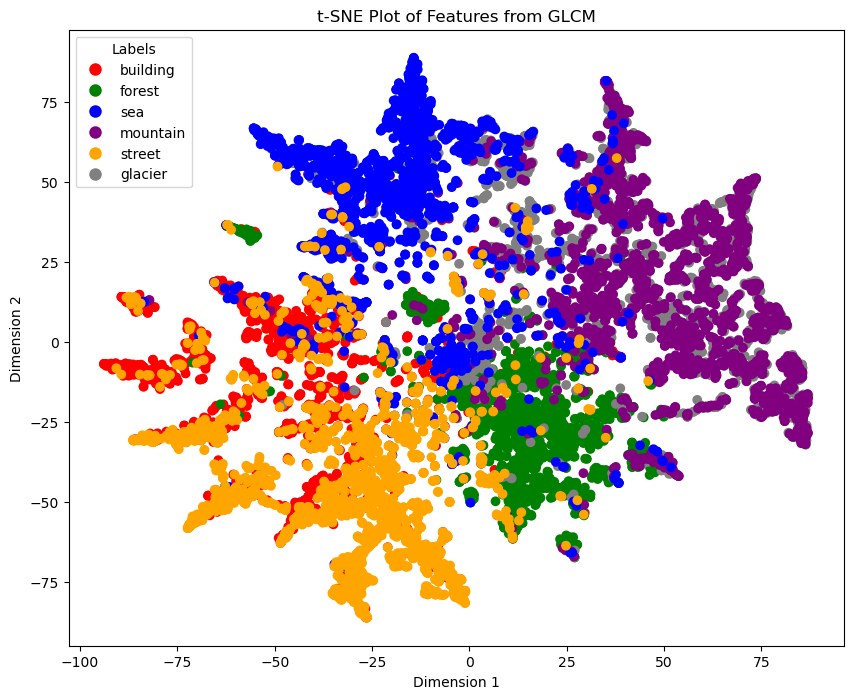

In [511]:
columns_to_drop = ['files', 'labels', 'train_or_val']
X = train_resnet.drop(columns=columns_to_drop)
y = train_resnet['labels']

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from ResNET')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

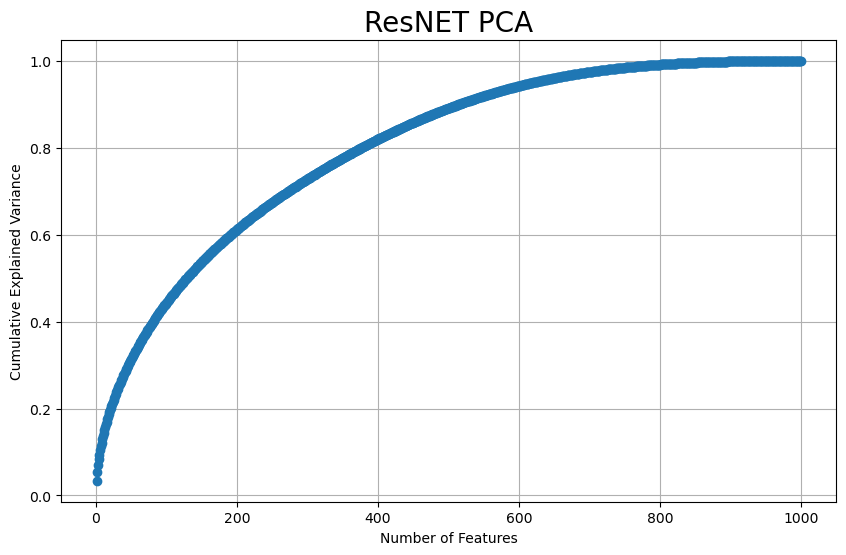

In [713]:
## PCA Visualisation

# # Drop specified columns
columns_to_drop = ['files', 'labels', 'train_or_val']
train_resnet = train_resnet.drop(columns=columns_to_drop)

# Standardize the data 
scaler = StandardScaler()
train_resnet_standardized = scaler.fit_transform(train_resnet)

# Apply PCA
pca = PCA()
pca.fit(train_resnet_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('ResNET PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Close

In [709]:
sum(df_test2.isnull().sum())

0

In [710]:
#fill nas for missing BOVW values
df_test2=df_test2.fillna(0, inplace=False)

In [711]:
df_train2.to_csv('train_all_features.csv')
df_val2.to_csv('val_all_features.csv')
df_test2.to_csv('test_all_features.csv')

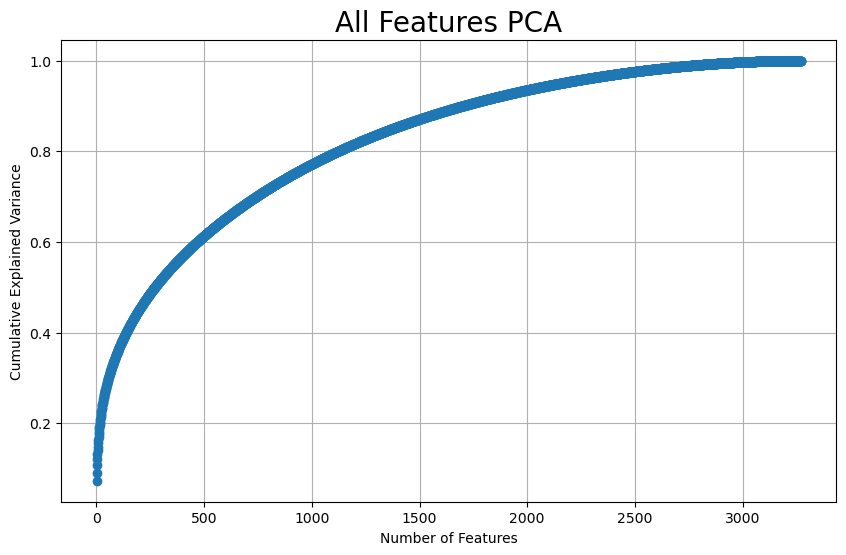

In [719]:
## All features PCA
# # Drop specified columns
columns_to_drop = ['files', 'labels', 'train_or_val']
df_train_pca = df_train2.drop(columns=columns_to_drop)

# Standardize the data 
scaler = StandardScaler()
train_standardized = scaler.fit_transform(df_train_pca)

# Apply PCA
pca = PCA()
pca.fit(train_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('All Features PCA', fontsize=20)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()